# Finding Koren tube parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Koren's model for tubes

Matlab code
```
function y = tucalc(x)
% IPTUBE calculates vacuum tube plate current in Amperes.
% The following parameters have changed from the 1996 model:
% KGX = KG1^EX is used inside exponent for optimization.
% KVB for TRIODE (now has units of volts).
% 8/25/2001: I'm returning them to the original model for compatibility.

global TubeType MU EX KG1 KGX KP KVB Vp Vg Vs Vsi Idata ERR VCT PENFN NOPT SOLVER

kvbb = KVB;

exx = EX;
if (strcmp(TubeType,'TRIODE') | (max(Vsi)-min(Vsi))/max(Vsi)>.3)
   exx = EX*x(2);  % Optimize on EX.
end

if (strcmp(TubeType,'TRIODE'))		% TRIODE
   if (length(x)>=5 & (max(Vg)+VCT)>eps)  kvbb = KVB*x(5)^2;  end
   E1 = Vp/(KP*x(4)).*log(1+exp(KP*x(4).* ...
      (1/(MU*x(1))+(Vg+VCT)./sqrt(kvbb+Vp.^2))));
   y = (E1./(KGX*x(3))).^exx.*(1+sign(E1));
elseif (strcmp(TubeType,'PENTODE'))		% PENTODE
   if (length(x)>=5)  kvbb = KVB*x(5);  end
   E1 = Vs./(KP*x(4)).*log(1+exp(KP*x(4).*(1/(MU*x(1))+(Vg+VCT)./Vs)));
   y = (E1./(KGX*x(3))).^exx.*(1+sign(E1));  % .*atan(Vp./kvbb);
   if     (PENFN == 2) y = pi/2*y.*(1-exp(-2*Vp/(pi*kvbb)));		% intermediate.
   elseif (PENFN == 3) y = pi/2*y.*tanh(2*Vp/(pi*kvbb));		% sharpest.
   else                y = y.*atan(Vp./kvbb);	% PENFN==1: roundest. In article.
   end
else error(['Bad
``` tube type: ',TubeType]);
end

Let's rewrite it in Python

## Read the tube variables

In [63]:
# defaults
RGI=2000 
CCG='22P'
CGP='1.8P' 
CCP='11P'
VCT = 0.0

In [64]:
tube = '6HV5A'
with open(f'{tube}.m', 'r') as f:
    tube_txt = f.read()

tube_txt = tube_txt.split('\n')
tube_name = tube_txt[0].split('=')[-1].replace('\'', '').replace(';', '').strip()
tube_source = tube_txt[1].split('=')[-1].replace('\'', '').replace(';', '').strip()

for tube_txt_el in tube_txt[2:]:
    for el in tube_txt_el.split(';'):
        vars = el.strip().split('=')
        
        if len(vars) == 2:
            var_name = vars[0].strip()
            var_value = vars[1].strip()
            
            if ':' in var_value:
                rng = var_value.split(':')
                var_value = f'np.arange({rng[0]},{float(rng[2]) + float(rng[1])},{rng[1]})'
            elif '[' in var_value:
                arr = [e for e in var_value[1:-1].split(' ') if e != '']
                var_value = f"[{','.join(arr)}]"
                # print(arr)
                
            
            exec(f'{var_name} = {var_value}')

# post processing
Vp = np.array(Vp)
Vg = np.array(Vg)
Idata = np.array(Idata)

## Find the best parameters

In [65]:

Vs = []
Vsi = Vs
KP = 800
EX = 1.35
KVB = 7
kvbb = KVB

KG1 = 1000
KGX = np.power(KG1, (1.0 / EX))

# https://numpy.org/doc/stable/user/numpy-for-matlab-users.html
def tube_current(x0, Vp = Vp, Vg = Vg):
    _mu = MU * x0[0]
    _exx = EX * x0[1]
    _kg1 = KGX * x0[2]
    _kp = KP * x0[3]


    if (len(x0) >= 5 and (max(Vg) + VCT) > np.spacing(1)):  
        _kvbb = KVB * np.power(x0[4], 2)
    else:
        _kvbb = KVB

    
    EL_Voltage = Vp / (KP * x0[3])      # (Ep / kp)
    EL_Exp = np.exp(
        _kp * 
        (
            (1 / _mu) + 
            (Vg + VCT) / np.sqrt(
                _kvbb + np.power(Vp, 2)
            )
        )
    )
    
    EL_Log = np.log(1 + EL_Exp)
    
    E1 =  EL_Voltage * EL_Log
    y = np.power(E1 / _kg1, _exx) * (1 + np.sign(E1));
    
    return y
    
# tube_current(np.ones(5))

In [66]:
import scipy.optimize

opt = lambda x: np.linalg.norm((tube_current(x) - Idata) * np.log(Idata) / Idata)
xopt = scipy.optimize.fmin(func=opt, x0=np.ones(5), maxiter=5000, ftol=1e-9, full_output=True, disp=True)

Optimization terminated successfully.
         Current function value: 0.232611
         Iterations: 365
         Function evaluations: 617


## Plot

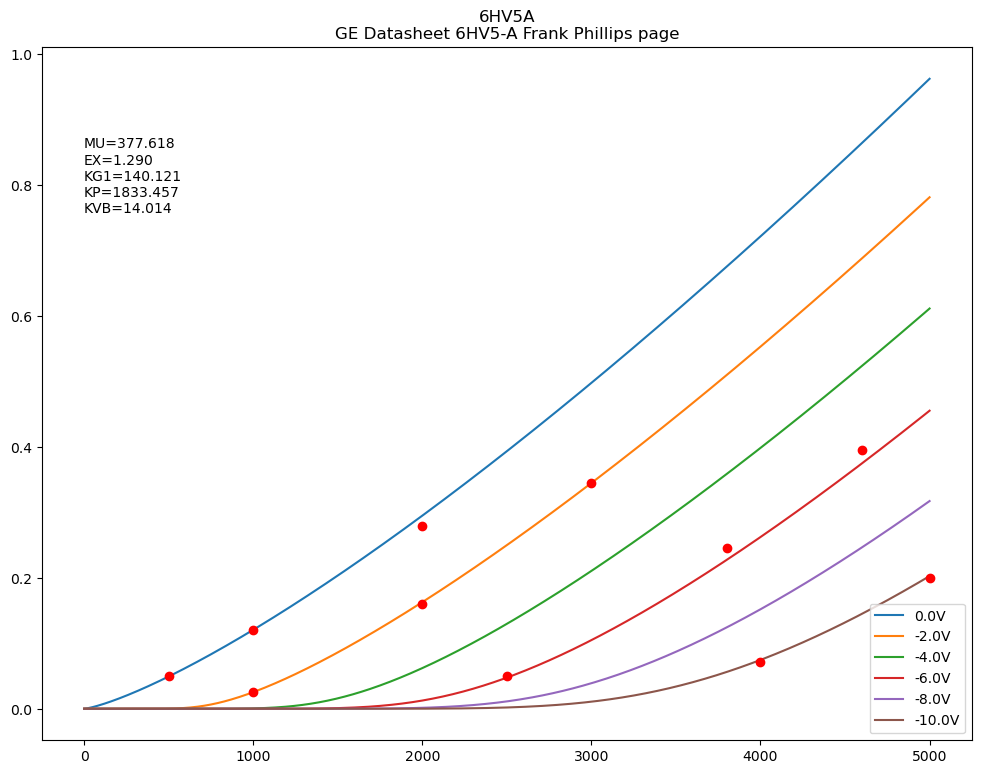

In [67]:
Vp_plot = []
Vg_plot = []
Vi_plot = []

for Vg_ind in VGP:
    Vpp = np.arange(0, Vpmax + 10, 10)
    Vgg = np.array([Vg_ind] * len(Vpp))
    Vii = np.array(tube_current(xopt[0], Vpp, Vgg))

    Vp_plot.append(Vpp)
    Vg_plot.append(Vg_ind)
    Vi_plot.append(Vii)

param_names = ['MU', 'EX', 'KG1', 'KP', 'KVB']
param_vals = list(xopt[0] * np.array([MU, EX, KG1, KP, KVB]))
param_txt = []

for p_nm, p_val in zip(param_names, param_vals):
    param_txt.append(f'{p_nm}={p_val:.3f}')
param_plot = '\n'.join(param_txt)

fig = plt.figure(figsize=(12,9))

for i, vgp in enumerate(Vg_plot):
    plt.plot(Vp_plot[i], Vi_plot[i], label=f'{vgp}V')

plt.plot(Vp, Idata, 'ro')
plt.title(f'{tube_name}\n{tube_source}')
plt.legend(loc='lower right')
lims = plt.axis()
plt.text(0, lims[-1] * .75 , param_plot)
plt.savefig(f'{tube_name}_fit_plot.png', dpi=300)

In [68]:
model = f'''.subckt {tube_name} A G K
* {tube_source}
XV1 A G K Triode
+params: {' '.join(param_txt)} VCT={VCT} RGI={RGI} CCG={CCG}  CGP={CGP} CCP={CCP}
.ends
'''
print(model)

.subckt 6HV5A A G K
* GE Datasheet 6HV5-A Frank Phillips page
XV1 A G K Triode
+params: MU=377.618 EX=1.290 KG1=140.121 KP=1833.457 KVB=14.014 VCT=0.0 RGI=2000 CCG=22P  CGP=1.8P CCP=11P
.ends



In [69]:
with open(f'{tube_name}.model', 'w') as f:
    f.write(model)

In [71]:
!mamba install -y click


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.15.3) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['click']

pkgs/main/osx-arm64      Using cache
pkgs/main/noarch         Using cache
pkgs/r/osx-arm